# NYC Taxi Ride Analysis & Prediction of Trip Duration

## Introduction

The analysis presented in this notebook is about the factors influencing the duration of the taxi rides in the New York City. The provided data is secondary and sourced from Kaggle. As per Kaggle, the primary dataset was released by NYC Taxi Commission and the Limousine Commission.

The structure of the current work can mainly be divided into, 
1. Explotatory Data Analysis :
    - Understanding the Data
    - Data Due Delligence
    - Data Cleaning/Pre-processing
    - Visualization of the locations and Time bins in relation with the trip duration
    - Possible clustering based on Duration of the trip
    - Variable influence on the Duration of the trip
2. Supervised Machine learning :
    - Feature Extraction and addition of external features
    - Data Modelling
    - Machine Learning Model Training
    - Model Testing
3. Discussion and Conclusion

## The Data Description

The given dataset as the following columns,

1. **id** - Unique identifier
2. **vendor_id** - Code of the provider of the trip record
3. **pickup_datetime** - Date and time of the pickup
4. **dropoff_datetime** - Date and time of the dropoff
5. **passenger_count** - Number of passengers in the corresponding trip
6. **pickup_longitude** - Location longitude where meter is engaged
7. **pickup_latitude** - Location latitude where the meter is engaged
8. **dropoff_longitude** - Location longitude where meter is engaged
9. **dropoff_latitude** - Location latitude where meter is engaged
10. **store_and_fwd_flg** - Y indicates the record was stored and retreived from car memory because of connection issues. N indicates that the record is pushed online to the server.
11. **trip_duration** - Duration of the corresponding trip in seconds


## The Context
Analysis of the taxi rides in the NYC can potentially help the private companies running the taxi business to understand problems within and improve the business to withstand high competetion from ride sharing services like Uber and Lyft. The below graph(Source: https://www.statista.com/chart/13480/ride-hailing-apps-surpass-regular-taxis-in-nyc/) shows the comparison between Taxis and Uber in terms of number of yearly pickups from the year 2009 to 2017.
It is clear that the usage of the Uber has surpassed the usage of Taxis by the year 2017 with a downward curve for the taxis that started in the year 2014.


<img src='NYC_TaxivsUber_Rides.PNG'/>

## The Use Case

To  withstand the competetion against Uber and Lyft, let us assume that the NYC Taxi Commission and Limousinen Commision in conjunction with the Taxi companies have decided to transform digitally the way Taxis are booked and managed, using a mobile app similar to how other ride hailing apps work. 
Predicting the duration of the trip based on the time and location and eventually predicting the price of the trip can be an extremely instrumental feature of the app given the predictions are made with least difference from the actual duration and price. This can be a key to the business model since e-ride hailing business models charge the customers based on slab systems rather than depending on the exact distance. This gives the customers and impression of not being overcharged as the customer pays exactly the same amount as prompted during the booking.
Metered taxis can still adhere to their current business model of charging by distance and time, and yet can achieve the idea of not giving the impression of overcharging the customer if the trip duration can be predicted as accurate as possible.
Prompting the customers with approximate trip duration and approximate price of the trip during the booking time and experiencing the same charges will actually increase the trust of the people over using the taxis and eventually help the business grow.
So in the current analysis, with the available data, relations between the predictors like pickup location, pickup time, dropoff location and dropoff time etc are analysed and more features are extracted to predict the trip duration as accurate as possible. Predicting the price of the trip is out of scope of this analysis.

## All the libraries used

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from statsmodels.stats import weightstats as stests
import time
from sklearn.cluster import KMeans
from matplotlib.pyplot import imread
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb

## Getting the data

In [2]:
#Import the dataset
#Setting the display options for pandas
pd.set_option('display.max_rows',100 )
df_train = pd.read_csv('./new-york-city-taxi-with-osrm/train.csv')
df_test = pd.read_csv('./new-york-city-taxi-with-osrm/test.csv')

### Looking at the Dataset

In [3]:
# Sample of the data
print("Training Data")
display(df_train.head())
print("")
print("Testing Data")
display(df_test.head())
#shape of the data
print("Shape of the training data set : {} rows and {} columns".format(df_train.shape[0],df_train.shape[1]))
print("Shape of the testing data set : {} rows and {} columns".format(df_test.shape[0],df_test.shape[1]))
#Data Types
print("")
print("Data Types")
display(df_train.dtypes)
print("")
print("Any null values in the dataset")
display(df_train.isnull().any())

Training Data


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435



Testing Data


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


Shape of the training data set : 1458644 rows and 11 columns
Shape of the testing data set : 625134 rows and 9 columns

Data Types


id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object


Any null values in the dataset


id                    False
vendor_id             False
pickup_datetime       False
dropoff_datetime      False
passenger_count       False
pickup_longitude      False
pickup_latitude       False
dropoff_longitude     False
dropoff_latitude      False
store_and_fwd_flag    False
trip_duration         False
dtype: bool

The above peice of code is to give us a basic insight of the data we are going to analyze. Findings,
1. The training data has about 1.4 million observations and testing set has about 0.6 million records for test.
2. We need to convert the datetime columns to python datetime.
3. store_and_fwd_flg needs to be converted to string
4. There are no missing values in the dataset, which is good :). **No imputations needed**
5. Testing dataset does not have the dropoff_datetime which is obvious.


### Data Due Diligence

1. **id Check for uniqueness**:
Check if the id is unique in the train dataset and the test dataset.

In [4]:
if df_train.id.nunique() == df_train.shape[0]:
    print('There are no duplicate ids in the training dataset')
else:
    print('Duplicate Records based on id!!')
if len(np.intersect1d(df_train.id.values, df_test.id.values)) == 0:
    print('Testing dataset does not have any ids from the training dataset')
else:
    print('There are training ids in testing data also')    

There are no duplicate ids in the training dataset
Testing dataset does not have any ids from the training dataset


With an assumption that every id represent a unique record in our dataset, there are no duplicate records in our data and also the test data does not have any record in common with the training dataset.

2. **store_and_fwd_flag**: Check the Store and Forward flag. Expected to have only 2 values

In [5]:

print(set(df_train.store_and_fwd_flag.unique()) | set(df_test.store_and_fwd_flag.unique()))

{'N', 'Y'}


Both the training and testing data has only 2 different values for the Store and Forward flag.

3. **Validate Trip Duration**: Check if the trip duration matches the time of pick up and time of drop off. This can be validated only in the training set. 

In [6]:
#pickup
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'])
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'])
#dropoff
df_train['dropoff_datetime'] = pd.to_datetime(df_train['dropoff_datetime'])
#calculate trip duration for validation
df_train['calc_trip_duration'] = (df_train['dropoff_datetime'] - df_train['pickup_datetime']).map(lambda z:z.total_seconds())

In [7]:
# Get all the records in the dataset which has difference between the trip duration and the calculated trip duration
diff_dur = df_train[np.abs(df_train['calc_trip_duration'].values - df_train['trip_duration'].values)>1]
if diff_dur.shape[0] > 0:
    print('The following records have conflicts in the trip duration and the pickup and dropoff times')
    displa(diff_dur)
else:
    print('Trip durations match the pickup and dropoff time difference. Nothing to worry about it!! :)')

Trip durations match the pickup and dropoff time difference. Nothing to worry about it!! :)


Trip Duration is validated against the pickup and drop off timings and looks fine.

Explore the trip durations

In [8]:
display(df_train['trip_duration'].describe())

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

The least recorded trip duration is 1 second and the highest recorded trip duration is 3526282 seconds (appx 1000 hours), this indicates a clear presence of outliers in the dataset because the average trip duration in the dataset is 959 seconds which is approximately 16 mins. Lets lol at the top 20 and bottom 20 values in the tri duration.

In [9]:
display(df_train.nlargest(20,['trip_duration'])['trip_duration'])

978383     3526282
924150     2227612
680594     2049578
355003     1939736
1234291      86392
295382       86391
73816        86390
59891        86387
1360439      86385
753765       86379
91717        86378
1221666      86378
66346        86377
1138915      86377
172662       86369
779030       86369
1269316      86369
1284067      86369
1213613      86367
1233528      86367
Name: trip_duration, dtype: int64

Lets look at the data points where the trip duration is more than and equal to 1939736 seconds (538 hours).

In [10]:
display(df_train[df_train['trip_duration']>86393])

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,calc_trip_duration
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,1939736,1939736.0
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,2049578,2049578.0
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,2227612,2227612.0
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,3526282,3526282.0


The pickup longitude latitude and dropoff longitude latitude are still within the City's borders. They are clearly a case of confusion and needs to be validated back on the data provider. The data might be valid for a possibility of long term hiring of the Taxis. For the purpose of visualization lets apply log to the trip duration.

In [11]:
def plotHistogram(values,bins,xlabel,ylabel,title):
    plt.hist(values,bins=bins)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    plt.close()

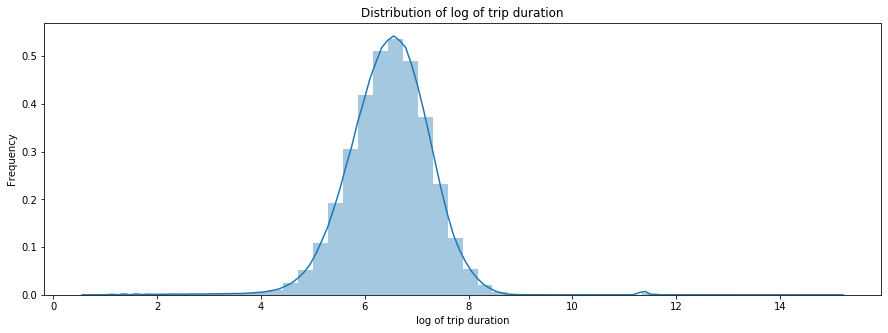

In [12]:
plt.rcParams["figure.figsize"] = (15,5)
#plotHistogram(np.log(df_train['trip_duration'].values+1), 50, xlabel='log of trip duration', ylabel='Frequency', title='Distribution of log of trip duration')
sns.distplot(np.log(df_train['trip_duration'].values+1))
plt.title('Distribution of log of trip duration')
plt.xlabel('log of trip duration')
plt.ylabel('Frequency')
plt.show()

The log of the trip duration plotted above looks pretty much a normal distribution. Lets use the log of the value to predict and log transform the value before we calculate the error. Error for the predictions made in the validation set are calculated using RMSE in the current work.

In [13]:
df_train['trip_duration_log'] = np.log(df_train['trip_duration'])

## Feature Selection

#### store_and_fwd_flag

The store_and_fwd_flag has 2 values defined in the dataset which are 'Y' and 'N'. 'Y' represents that the corrsponding record was stored in the taxi's memory before the data is pushed to the server due to connection unavailability issues and 'N' indicates that the corresponding record was pused to the server online.

The following box and whiskers plot is to identify if the store_and_fwd_flag has any influence on the duration of the trip.

**Note** - For the purpose of visualization, all the outliers are omitted in the plot to understand the distribution.

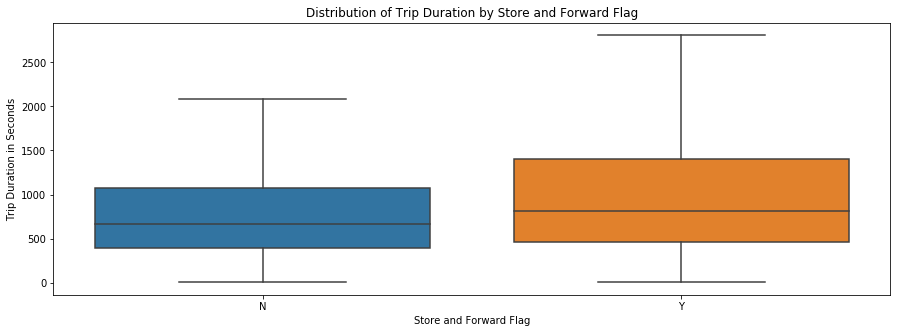

In [14]:
plt.rcParams["figure.figsize"] = (15,5)
plt.title('Distribution of Trip Duration by Store and Forward Flag')
display(sns.boxplot(x='store_and_fwd_flag', y = 'trip_duration', data=df_train, showfliers=False))
plt.xlabel('Store and Forward Flag')
plt.ylabel('Trip Duration in Seconds')
plt.show()

The plot shows the second quartile, median and the third quartile are relatively high when the store_and_fwd_flag is 'Y' compared to the box plot of 'N'. This cannot be a case of causation because in practical, the taxi being offline has nothing in relation with the trip duration being high. But if the difference is significant that when the store_and_fwd_flag is 'Y' the trip is clocking longer, this is a case of investigation to find if this is the application fault or if this is a case of manual tamperings or errors.

##### Hypothesis Testing : store_and_fwd_flg

Null Hypothesis (H_0) : The means of the trip duration are same for the store_and_fwd_flg groups 'Y' and 'N'

Alternate Hypothesis(H_1) : The means are different.

In [15]:
arr_trip_dur_Y = df_train[df_train['store_and_fwd_flag'] == 'Y']['trip_duration_log'].values
arr_trip_dur_N = df_train[df_train['store_and_fwd_flag'] == 'N']['trip_duration_log'].values

# Assuming the standard deviations of the groups are same and the default confidence interval is 95%
ztest,zpval = stests.ztest(arr_trip_dur_Y, x2=arr_trip_dur_N, value=0,alternative='two-sided')
print('p-val for the hypothesis:',zpval)
if zpval<0.05:
    print('We reject the Null Hypothesis')
else:
    zprint('We fail to reject the Null Hypthesis')


p-val for the hypothesis: 5.663848989903829e-75
We reject the Null Hypothesis


From the above hypothesis testing, we have rejected the Null Hypothesis that the group means are same for both the groups. Hence the trip durations are significantly longer for the trips recorded with the store_and_fwd_flag as 'Y'. Though this is not a case of causation, we can have this variable in the dataset as a predictor that will influence the duration of the trip.

**Store and forward flag shows significant difference in trip durations, but practically this makes no sense. We are not going to use it in our prediction**

#### passenger_count

Passenger count indicates the number of passengers that boarded the taxi for the corresponding trip. The following line of code describes basic properties of the passenger_count in the training and testing dataset

In [16]:
print("Training Data Set")
display(df_train['passenger_count'].describe())
print("Testing Data Set")
display(df_test['passenger_count'].describe())

Training Data Set


count    1.458644e+06
mean     1.664530e+00
std      1.314242e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: float64

Testing Data Set


count    625134.000000
mean          1.661765
std           1.311293
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           9.000000
Name: passenger_count, dtype: float64

The distribution of the passenger_count in the training and the testing datasets look very similar.

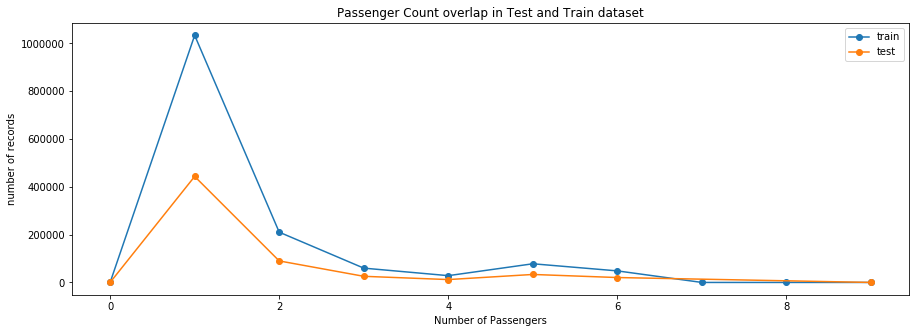

In [17]:
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(df_train.groupby('passenger_count').count()[['id']], 'o-', label='train')
plt.plot(df_test.groupby('passenger_count').count()[['id']], 'o-', label='test')
plt.title('Passenger Count overlap in Test and Train dataset')
plt.legend(loc=0)
plt.ylabel('number of records')
plt.xlabel('Number of Passengers')
plt.show()

The range of the passenger count is same in both the testing and the training datasets. This helps us to extract the same feature in both training and testing data as we are not have any point in testing data that is out of the training data.

Lets plot the correlation between the passengern count and the trip duration

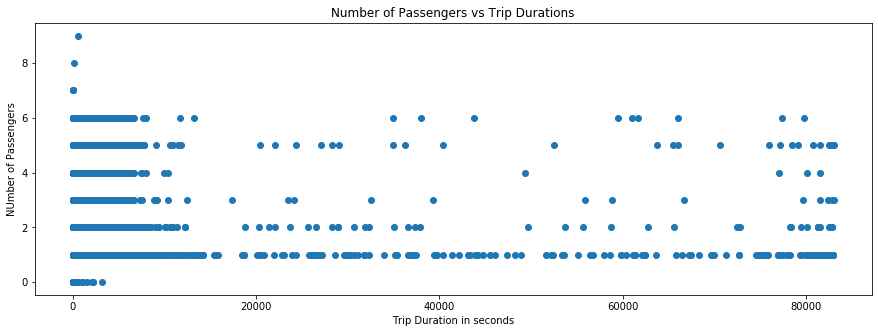

In [18]:
#to understand the plot, all the trip durations more than 83000 seconds are avoided due too the presence of outliers
plt.rcParams["figure.figsize"] = (15,5)
plt.title('Number of Passengers vs Trip Durations')
plt.xlabel('Trip Duration in seconds')
plt.ylabel('NUmber of Passengers')
sct_tp_dur = df_train[df_train['trip_duration'] < 83000]
plt.scatter(sct_tp_dur['trip_duration'], sct_tp_dur['passenger_count'].values)
plt.show()

##### Observations from the plot
1. The duration of the trip is recorded always low when the number of passengers are 0, 7, 8 and 9.
2. The range of the duration trips covers the lowest to the highest for the number of passenger counts 1 to 6.
3. When the passanger count is 1, the trip duration's standard deviation is lower compared to passenger counts 2, 3, 4, 5 and 6.

Since the plot shows significant differences in the trip durations clocked for various number of passengers, this can be used a good predictor in determining the estimated trip duration. However, in practical, the number of passengers would not influence the trip duration unless some assumptions are made as following, 

a. There are multiple stops made as the destinations for the passengers could be different.

b.  For passenger count more than 6, it is probably not a yellow or green taxi, but a limousine or a bigger vehicle booked by a 
group where the destination is single point for the group.

c. When the passenger count is 0, it is probably the booking made for deliveries or to reach a customer. (This needs to be checked with the taxi companies of understanding the cases where the number of passengers are 0).

Since the difference in passenger count groups are very significant from the plot, Hypothesis testing is skipped for the variable passenger_count.

**Number of Passengers can be a good predictor for Trip Duration**

#### vendor_id

The vendor_id represnts the code of the vendor who is responsible for recording the observations in relation to the trip. Ideally, the vendor_id should not have any relation to the duration of the trip. But analysing it is important to unserstand that if this is influencing the trip durations in the provided dataset, there is definetly a problem with the way the vendors are recording the trip observation and calculating the trip duration.

In [19]:
display('training data',df_train['vendor_id'].unique())
display(df_train['vendor_id'].describe())
display('testing data',df_test['vendor_id'].unique())
display(df_test['vendor_id'].describe())

'training data'

array([2, 1], dtype=int64)

count    1.458644e+06
mean     1.534950e+00
std      4.987772e-01
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      2.000000e+00
max      2.000000e+00
Name: vendor_id, dtype: float64

'testing data'

array([1, 2], dtype=int64)

count    625134.000000
mean          1.534884
std           0.498782
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           2.000000
Name: vendor_id, dtype: float64

There are only 2 vendors with codes 1 and 2 in both the training and the testing dataset.

The following boxplot helps us to visualize if there are any significant differences in the trip duration for various vendors.

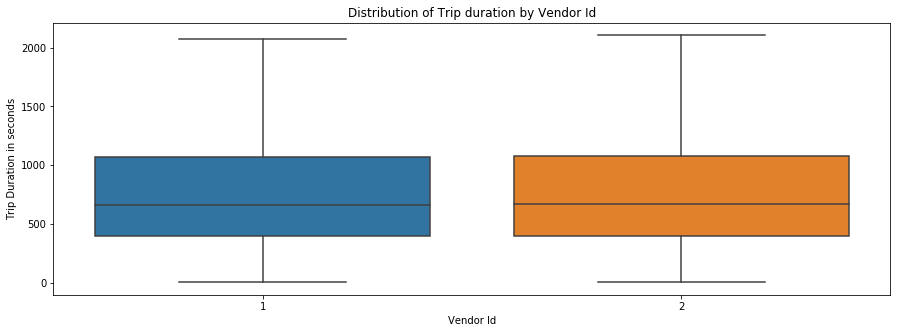

In [20]:
plt.rcParams["figure.figsize"] = (15,5)
plt.title('Distribution of Trip duration by Vendor Id')
display(sns.boxplot(x='vendor_id', y = 'trip_duration', data=df_train, showfliers=False))
plt.xlabel('Vendor Id')
plt.ylabel('Trip Duration in seconds')
plt.show()

Removing the outliers, we cannot observe any significant difference between the trip duration means for the groups in vendor id. 

**The Vendor id has no influence on the trip durations**

#### pickup_datetime

The pickup_datetime represent the date and time of the meter engagement for the corresponding trip. This should have a huge influence on the trip duration as there are always traffic peak hours and traffic nadir hours in relation to the time. In relation to the date, there might be a lot of difference in the traffic during the weekdays and the weekends. Lets analyze the influence of the pick_datetime field over the tip duration by considering the date and time seperately.

Lets check the overlap of the pickup_datetime field in the training and testing set.

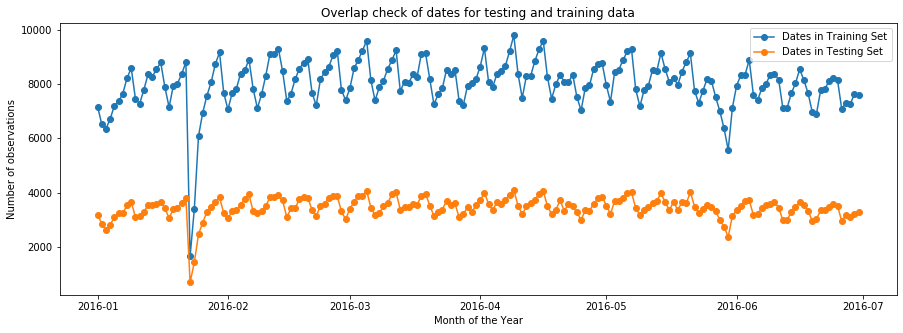

In [21]:
df_train['pickup_date'] = df_train['pickup_datetime'].dt.date
df_test['pickup_date'] = df_test['pickup_datetime'].dt.date
plt.plot(df_train.groupby('pickup_date').count()[['id']], 'o-', label='Dates in Training Set')
plt.plot(df_test.groupby('pickup_date').count()[['id']], 'o-', label='Dates in Testing Set')
plt.title('Overlap check of dates for testing and training data')
plt.legend(loc='best')
plt.ylabel('Number of observations')
plt.xlabel('Month of the Year')
plt.show()

The prediction model is not expected to predict anything in future as the testing dataset is having the same range of dates as the training dataset.

The provided dataset is from the year 2016 for the months January to July. To understand the influence of the date, we can extract two features namely "Day of Week" and "Day of Month" to analyze the influence on the trip duration. For our analysis lets extract "day of week" as group to understand if there is any difference in the trip duration based on the feature.

##### Day of Week

In [22]:
#extracting pickup day of week feature
df_train['pickup_day_of_week'] = df_train['pickup_datetime'].dt.day_name()

The following box plot helps us understand the difference in distributions of the trip duration based on day of week. The means of each group are also marked on the box plots. Note that the outliers are avoided in the visualization to get a better picture of the distribution.

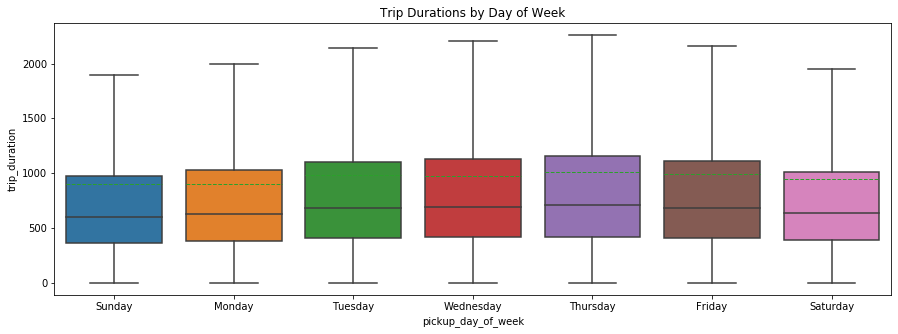

In [23]:
plt.rcParams["figure.figsize"] = (15,5)
plt.title('Trip Durations by Day of Week')
display(sns.boxplot(x='pickup_day_of_week', y = 'trip_duration', data=df_train,showfliers=False, 
                    order = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'], meanline=True, showmeans=True))

The plot shows the distribution of the trip durations based on day of week. The green dotted line inside the boxes indicate the mean of the group.

The value of the second quartile is very similar to all the groups but there are significant differences on the third quartile for each group. Certain trip durations increase with the day of week until thursday and then take a decreasing trend until Monday. The plot shows there is defenitely an influence of day of week on the trip duration, the similarities in the lower bounds can be explained more by including hour of the day as well.

For example, we can assume that the traffic is same anyday of the week at 5am as this can be considered a nadir traffic hour in the NYC. However, the intensity of traffic may vary at 10am based on the day of week.

Let is perform a one way ANOVA to compare the group means.

**Null Hypothesis H_0**: The group means of trip durations by day of week are same.

**Alternate Hypothesis H_1**: The group means are different.

In [24]:
groups = pd.unique(df_train['pickup_day_of_week'])
d_data = {grp:df_train['trip_duration'][df_train.pickup_day_of_week == grp] for grp in groups}

F, p = f_oneway(d_data['Sunday'], d_data['Monday'], d_data['Tuesday'], d_data['Wednesday'],d_data['Thursday'], d_data['Friday'], d_data['Saturday'])
print("p-value for significance is: ", p)
if p<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

p-value for significance is:  1.1977220482771511e-15
reject null hypothesis


The p-value of the oneway ANOVA test is very small, we have considered our confidence interval as 95%, since the p-value is less than 5%, we reject the Null Hypothesis and confirm that the group means are different for trip durations that are grouped by the day of week.

##### Month of the Year

Similar to the influence of day of week on the trip duration we can also explore the influence of Month of the Year has any influence on the trip duration.

In [25]:
df_train['pickup_Month'] = df_train['pickup_datetime'].dt.month_name()

The following boxplot can help us understand the difference of distribution in the in the trip durations with respect to the month of the year.

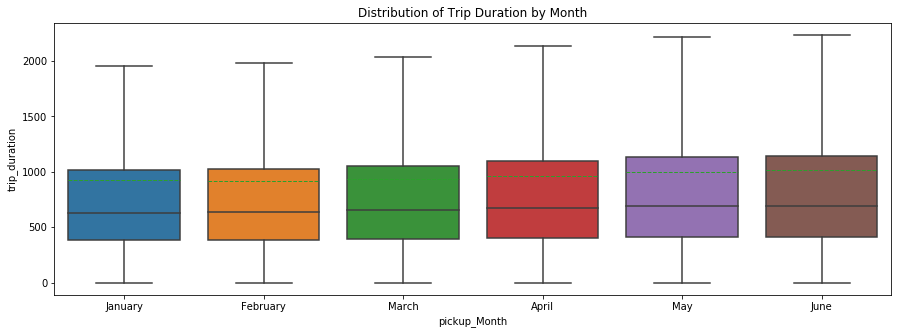

In [26]:
plt.rcParams["figure.figsize"] = (15,5)
plt.title('Distribution of Trip Duration by Month')
display(sns.boxplot(x='pickup_Month', y = 'trip_duration', data=df_train, showfliers=False, 
                    order = ['January','February','March','April','May','June'], meanline=True, showmeans=True))

Form the above box plot it can be observed that though the lower ranges of the trip duration remained same over the months, the upper quartiles have gradually increased over the month from January to June.

Let is perform a oneway ANOVA to check if the group means are same or different.

In [27]:
group_mths = pd.unique(df_train['pickup_Month'])
d_data_mths = {grp:df_train['trip_duration'][df_train.pickup_Month == grp] for grp in group_mths}

F, p = f_oneway(d_data_mths['January'], d_data_mths['February'], 
                d_data_mths['March'], d_data_mths['April'],d_data_mths['May'], d_data_mths['June'])
print("p-value for significance is: ", p)
if p<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

p-value for significance is:  2.1420687099537007e-13
reject null hypothesis


Since the p-value is less then 5%, we reject the Null Hypothesis that the group means are same. Which means the trip duration is influenced by the month of the year.

**Month of the Year is a good predictor for Trip Duration**

##### Time of the day

Time of the day can be very important feature in predicting the trip duration. A day can be divided into 24 hours, the intensity of traffic that influnces the trip durations would vary at different hours of a day. Lets visualize the variation of taxi engagements based on the hours of the day.

Lets plot the locations of the pickup and dropoff based on longitudes and latitudes of the NYC. 

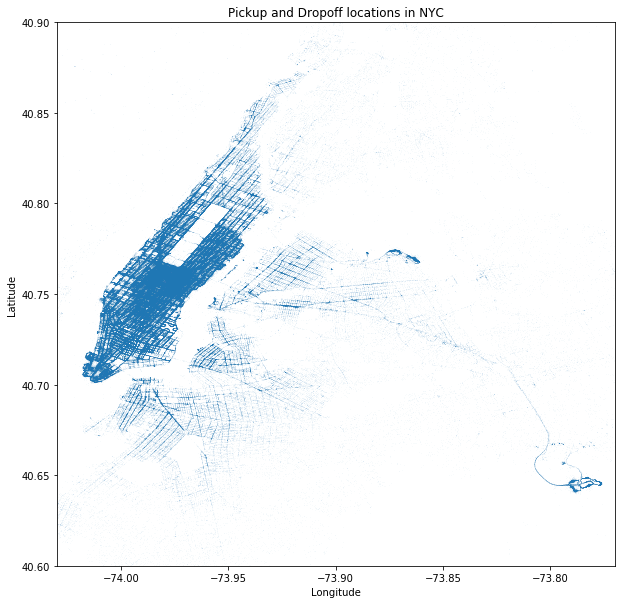

In [28]:
longitude = list(df_train.pickup_longitude) + list(df_train.dropoff_longitude)
latitude = list(df_train.pickup_latitude) + list(df_train.dropoff_latitude)
plt.figure(figsize = (10,10))
plt.plot(longitude,latitude,'.', alpha = 0.4, markersize = 0.05)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-74.03, -73.77)
plt.ylim(40.6,40.9)
plt.title('Pickup and Dropoff locations in NYC')
plt.show()

It is easy to understand the influence of the hour of the day on the trip duration if the pickup and dropoff longitudes and latitudes are plotted based on each hour of the day. The following line of code is to visualize the taxi engagements on an hourly basis.

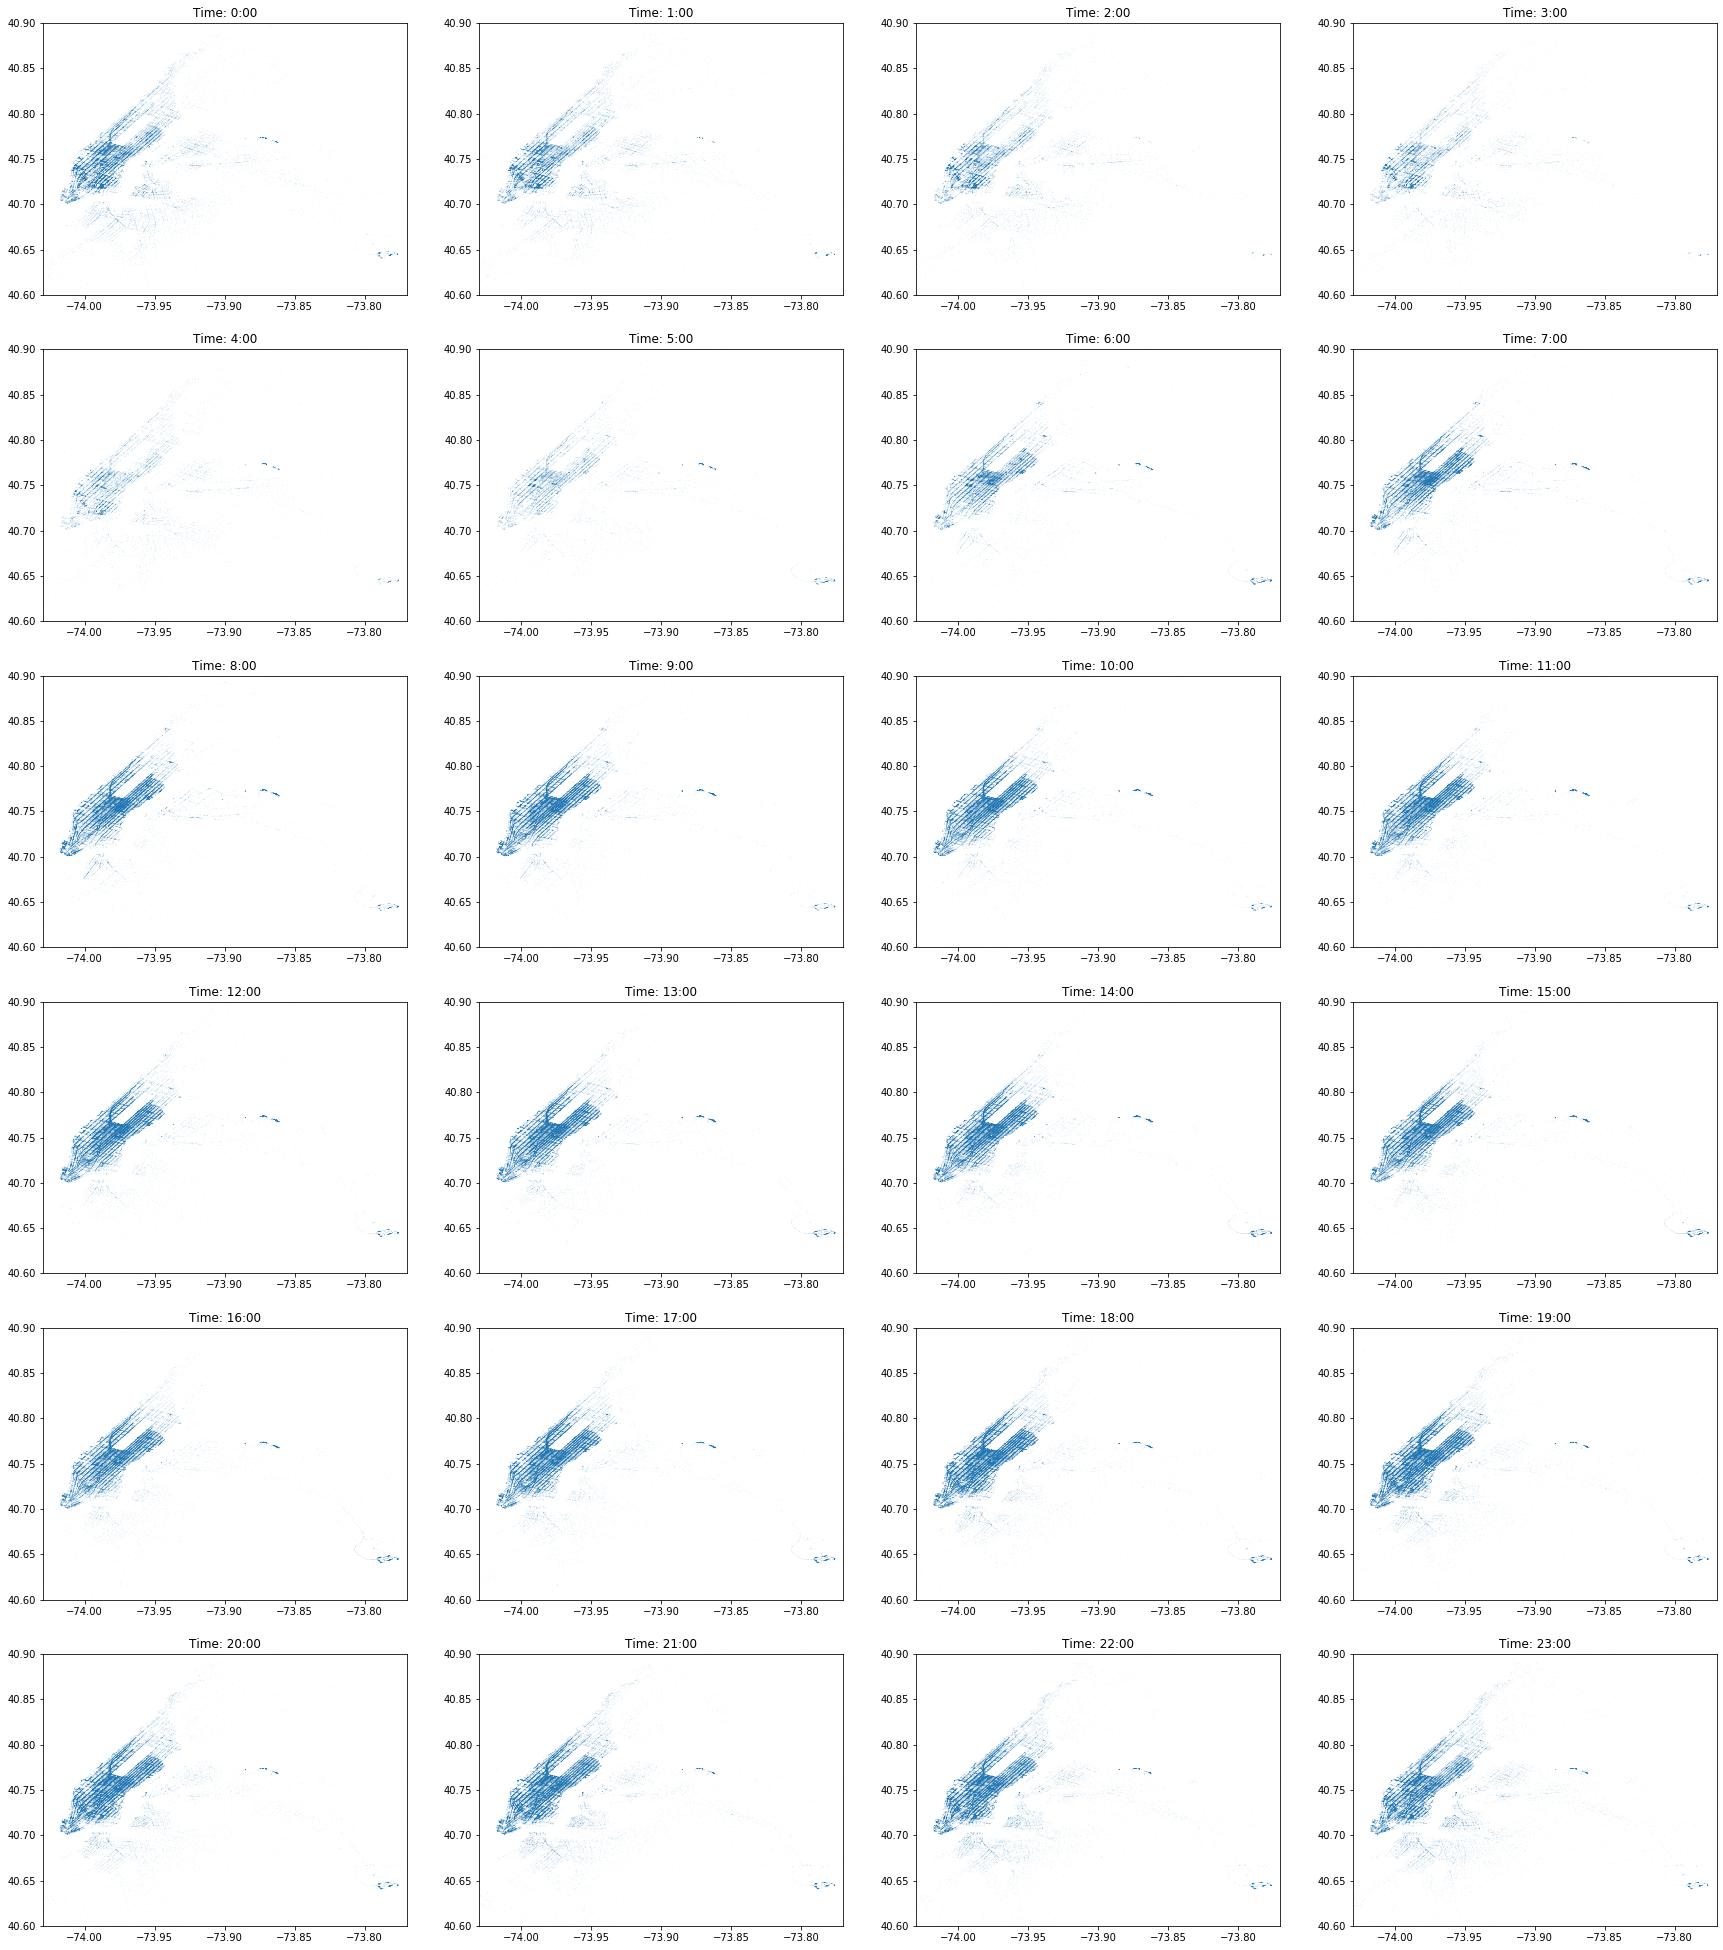

In [29]:
df_train['hour'] = df_train['pickup_datetime'].dt.hour
hour=0
plt.rcParams['figure.figsize'] = (30,35)
fig,ax = plt.subplots(nrows=6,ncols=4)
for row in ax:
    for col in row:
        train_data_new = df_train.loc[df_train['hour'] == hour]
        longitude = list(train_data_new.pickup_longitude) + list(train_data_new.dropoff_longitude)
        latitude = list(train_data_new.pickup_latitude) + list(train_data_new.dropoff_latitude)
        col.plot(longitude,latitude,'.', alpha = 0.4, markersize = 0.05)
        col.set_title('Time: {}:00'.format(hour))
        col.set_xlim(-74.03, -73.77)
        col.set_ylim(40.6,40.9)
        hour +=1
        

the plots above shows the taxi engagements across the New york City at different hours of the day. At certain hours the booking are high which also implies heavy traffic leading to longer trip durations and the hours where the bookings are low implies less traffic and hence faster trip durations.

It is observed that the hour of the day influences the trip duration significantly and hence we consider to keep the hour of the day as predictor of the trip duration.

**Since 'hour of the day', 'day of week' and 'Month of the Year' are having influence on the trip duration, we choose to keep features extracted from pickup_datetime to be used in training the prediction model.**

#### pickup_longitude, pickup_latitude, dropoff_longitude and dropoff_latitude

The longitude and latitude points of the taxi ride will have high influence on the duration of the trip. Certain location in the City could be always busy resulting in high traffic compared to other locations of the City thus influencing the duration of the trip.

The below plot shows the overlap of the locations in training and testing dataset.

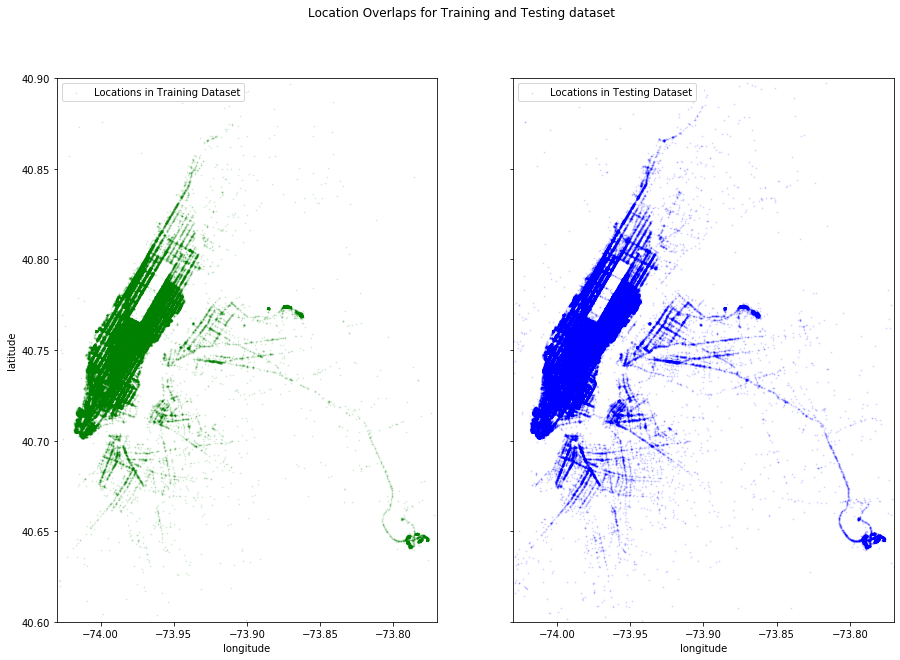

In [30]:
plt.rcParams["figure.figsize"] = (15,10)
city_long_border = (-74.03, -73.77)
city_lat_border = (40.6,40.9)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(df_train['pickup_longitude'].values[:200000], df_train['pickup_latitude'].values[:200000],
              color='green', s=1, label='Locations in Training Dataset', alpha=0.1)
ax[1].scatter(df_test['pickup_longitude'].values, df_test['pickup_latitude'].values,
              color='blue', s=1, label='Locations in Testing Dataset', alpha=0.1)
fig.suptitle('Location Overlaps for Training and Testing dataset')
ax[0].legend(loc='best')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc='best')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

The locations in the training and testing set completely ovelap. we can extract the same feature types for testing and training set similarly for features based on the locations.

##### Pickup Location : pickup_longitude, pickup_latitude

Let us cluster the data based on the location to make each cluster represent a group.

In [31]:
df_location_pickup = df_train[['pickup_longitude','pickup_latitude']]

In [32]:
kmeans = KMeans(n_clusters=15, random_state=0, n_init = 7).fit(df_location_pickup)
df_location_pickup.loc[:,'label'] = kmeans.labels_



C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:1046: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


We have divided the dataset into 10 clusters, The number of clusters is a random pick, To get the ideal number of clusters, we can build an elbow plot and decide the number of clusters. The New York City divided into 10 clusters based on the pickup locations can be visualized as follows.

In [33]:
bbox = (-74.03,-73.77,40.6,40.9)
nyc_map = imread('./NYC_Map.png')

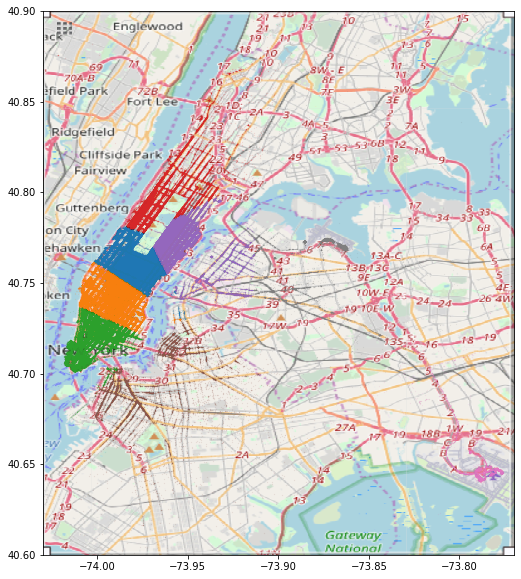

In [34]:
fig, ax = plt.subplots(figsize = (10,10))
for label in df_location_pickup.label.unique():
    ax.plot(df_location_pickup.pickup_longitude[df_location_pickup.label == label],
            df_location_pickup.pickup_latitude[df_location_pickup.label == label],'.', alpha = 0.3, markersize = 0.3)
ax.imshow(nyc_map, zorder=0, extent = bbox, aspect= 'equal')

From the above map we can clearly observe divisions of clusters in the New York City based on the longitudes and latitudes.
Let us consider each cluster as a group and check if the means of trip durations are same or different for all the groups.

In [35]:
#Assigning the cluster to the training set
df_train['pickup_loc_cluster'] = df_location_pickup['label']

The below box plot shows the distribution of the trip durations based on location clusters

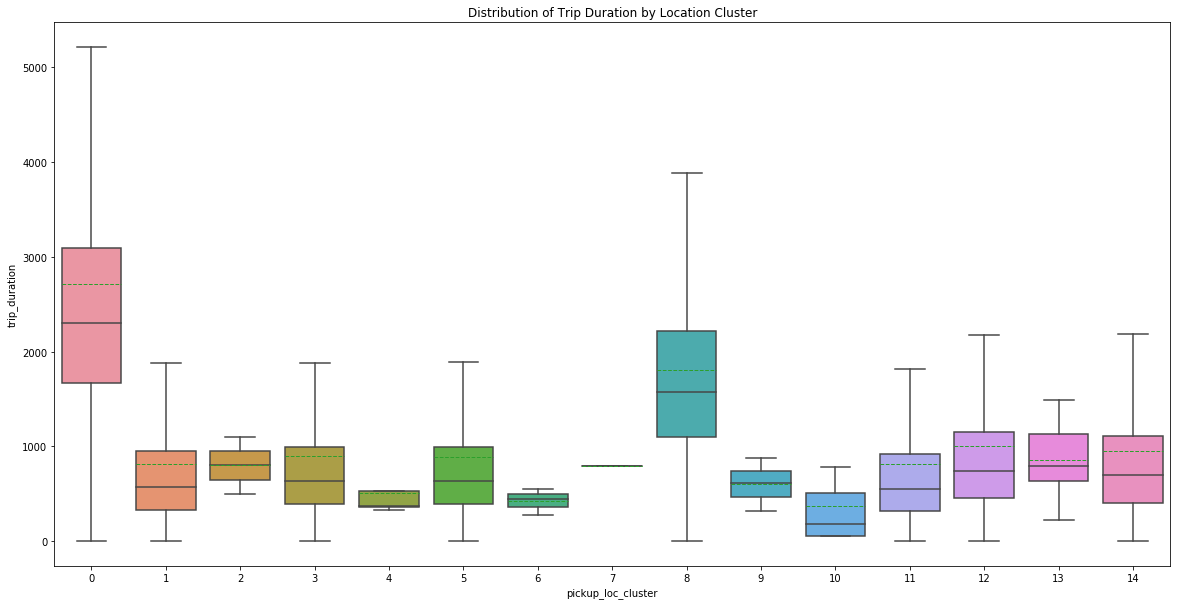

In [36]:
plt.rcParams["figure.figsize"] = (20,10)
plt.title('Distribution of Trip Duration by Location Cluster')
display(sns.boxplot(x='pickup_loc_cluster', y = 'trip_duration', data=df_train, showfliers=False, meanline=True, showmeans=True))

The distribution of the trip duration based on the pickup location are significantly different for each location. Features extracted based on the pickup location can be instrumental predictors of trip duration.

**pickup_Longitude, pickup_latitude will be kept for training the predictive model** 

##### Dropoff Location : dropoff_longitude, dropoff_latitude

In [37]:
df_location_dropoff = df_train[['dropoff_longitude','dropoff_latitude']]
kmeans = KMeans(n_clusters=15, random_state=0, n_init = 7).fit(df_location_dropoff)
df_location_dropoff.loc[:,'label'] = kmeans.labels_

df_train['dropoff_loc_cluster'] = df_location_dropoff['label']


C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:1046: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


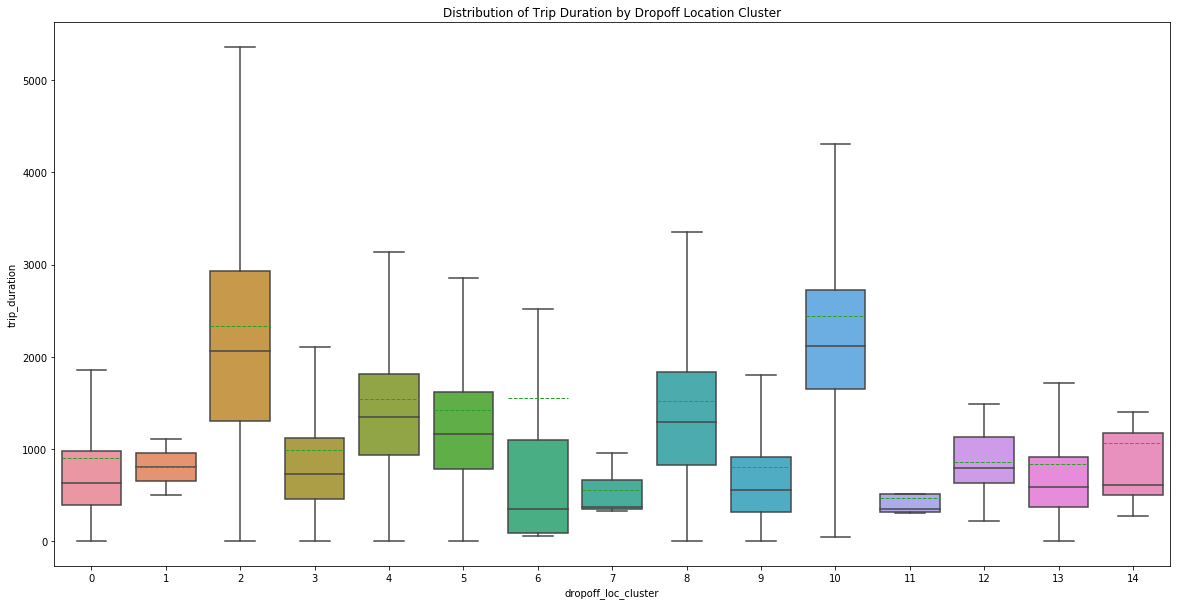

In [38]:
plt.rcParams["figure.figsize"] = (20,10)
plt.title('Distribution of Trip Duration by Dropoff Location Cluster')
display(sns.boxplot(x='dropoff_loc_cluster', y = 'trip_duration', data=df_train, showfliers=False, meanline=True, showmeans=True))

The means of the trip duration divided by the clusters representing the dropoff location are significantly different. Hence we can include features extracted useing the dropoff_longitude and dropoff_latitude.

**dropoff_Longitude, dropoff_latitude will be kept for training the predictive model** 

## Feature Extraction

The default provided list of features are explored until now. The only feature which did not have any reason to be included in the dataset for training the model is the vendor_id. In the following section, we shall extract as many features as possible from the default list of features for training the prediction model.

In [39]:
#Lets take dataframes afresh to avoid cleaning the dataframes that were changed during the analysis
df_train = pd.read_csv('./new-york-city-taxi-with-osrm/train.csv')
df_test = pd.read_csv('./new-york-city-taxi-with-osrm/test.csv')

#### Store and Forward Flag

There are only 2 possible values for this feature which are Y and N. This needs to be converted to binary format.

In [40]:
encoder = LabelEncoder()
encoder.fit(df_train['store_and_fwd_flag'])
df_train['store_and_fwd_flag'] = encoder.transform(df_train['store_and_fwd_flag'])
df_test['store_and_fwd_flag'] = encoder.transform(df_test['store_and_fwd_flag'])

display(df_train['store_and_fwd_flag'].unique())

array([0, 1])

#### Location

In [41]:
stacked_locs = np.vstack((df_train[['pickup_latitude', 'pickup_longitude']].values,
                    df_train[['dropoff_latitude', 'dropoff_longitude']].values,
                    df_test[['pickup_latitude', 'pickup_longitude']].values,
                    df_test[['dropoff_latitude', 'dropoff_longitude']].values))

In [42]:
pca = PCA().fit(stacked_locs)
df_train['pickup_pca_lat'] = pca.transform(df_train[['pickup_latitude', 'pickup_longitude']])[:, 0]
df_train['pickup_pca_lon'] = pca.transform(df_train[['pickup_latitude', 'pickup_longitude']])[:, 1]
df_train['dropoff_pca_lat'] = pca.transform(df_train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
df_train['dropoff_pca_lon'] = pca.transform(df_train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
df_test['pickup_pca_lat'] = pca.transform(df_test[['pickup_latitude', 'pickup_longitude']])[:, 0]
df_test['pickup_pca_lon'] = pca.transform(df_test[['pickup_latitude', 'pickup_longitude']])[:, 1]
df_test['dropoff_pca_lat'] = pca.transform(df_test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
df_test['dropoff_pca_lon'] = pca.transform(df_test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

We have used PCA to reduce the scale of the longitude and latitude coordinates.

The transformation can be validated by plotting the transformed longitudes and latitudes.

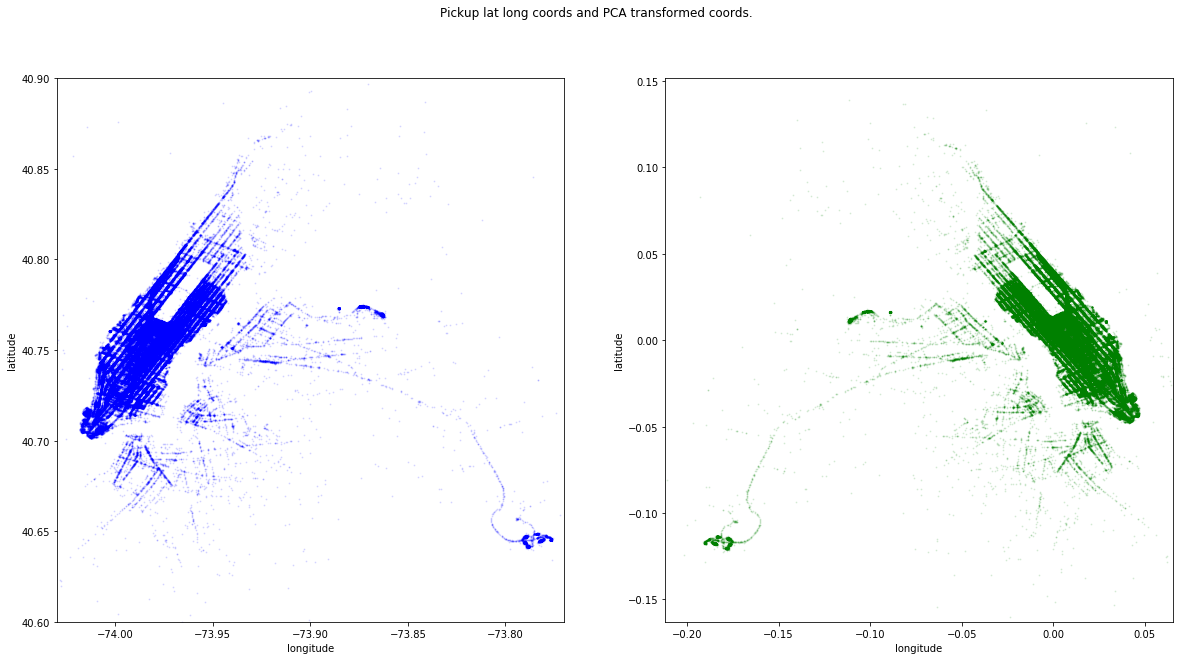

In [43]:
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(df_train['pickup_longitude'].values[:200000], df_train['pickup_latitude'].values[:200000],
              color='blue', s=1, alpha=0.1)
ax[1].scatter(df_train['pickup_pca_lat'].values[:200000], df_train['pickup_pca_lon'].values[:200000],
              color='green', s=1, alpha=0.1)
fig.suptitle('Pickup lat long coords and PCA transformed coords.')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].set_ylabel('latitude')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders = pca.transform([[x, y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:, 0].min(), pca_borders[:, 0].max())
ax[1].set_ylim(pca_borders[:, 1].min(), pca_borders[:, 1].max())
plt.show()

By the plots above, we can confirm the scales of the longitudes and latitudes are transformed with the means of both the coordinates centered around 0. 

#### Time and Date Features

The list of features we are extracting from the datetime are as follows,
1. Date
2. Minute
3. Hour
4. Day of the week
5. Week of the year


In [44]:
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'])
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'])

df_train.loc[:, 'pickup_weekday'] = df_train['pickup_datetime'].dt.weekday
df_train.loc[:, 'pickup_weekofyear'] = df_train['pickup_datetime'].dt.weekofyear
df_train.loc[:, 'pickup_hour'] = df_train['pickup_datetime'].dt.hour
df_train.loc[:, 'pickup_minute'] = df_train['pickup_datetime'].dt.minute
df_train.loc[:, 'pickup_dt'] = (df_train['pickup_datetime'] - df_train['pickup_datetime'].min()).dt.total_seconds()


df_test.loc[:, 'pickup_weekday'] = df_test['pickup_datetime'].dt.weekday
df_test.loc[:, 'pickup_weekofyear'] = df_test['pickup_datetime'].dt.weekofyear
df_test.loc[:, 'pickup_hour'] = df_test['pickup_datetime'].dt.hour
df_test.loc[:, 'pickup_minute'] = df_test['pickup_datetime'].dt.minute
df_test.loc[:, 'pickup_dt'] = (df_test['pickup_datetime'] - df_test['pickup_datetime'].min()).dt.total_seconds()


#### Distance Features

Haversine distance is described as great circle distance used for calculating distance between two point on a sphere. Though we do not know the actual distance covered as we are not aware of the root taken, we can calculate the haversine distance between the coordinates and used it as one of the features.

In [45]:
def getHaversineDist(lat_pick,lon_pick,lat_drp,lon_drp):
    lat_pick,lon_pick,lat_drp,lon_drp = map(np.radians, (lat_pick,lon_pick,lat_drp,lon_drp))
    earth_radius = 6371  # in km
    lat = lat_drp - lat_pick
    lng = lon_drp - lon_pick
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat_pick) * np.cos(lat_drp) * np.sin(lng * 0.5) ** 2
    h = 2 * earth_radius * np.arcsin(np.sqrt(d))
    return h
# Source : https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points

Bearing distance is described as the horizontal direction between two objects, in our case it is the pickup and dropoff locations. We can use this as a feature.

In [46]:
def getBearingDirection(lat_pick,lon_pick,lat_drp,lon_drp):
    lat_pick,lon_pick,lat_drp,lon_drp = map(np.radians, (lat_pick,lon_pick,lat_drp,lon_drp))
    earth_radius = 6371  # in km
    lng_delta_rad = np.radians(lon_drp - lon_pick)
    y = np.sin(lng_delta_rad) * np.cos(lat_drp)
    x = np.cos(lat_pick) * np.sin(lat_drp) - np.sin(lat_pick) * np.cos(lat_drp) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))
#Source : https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points

In [47]:
df_train.loc[:, 'distance_haversine'] = getHaversineDist(df_train['pickup_latitude'].values, 
                                                         df_train['pickup_longitude'].values, 
                                                         df_train['dropoff_latitude'].values, 
                                                         df_train['dropoff_longitude'].values)
df_test.loc[:, 'distance_haversine'] = getHaversineDist(df_test['pickup_latitude'].values, 
                                                        df_test['pickup_longitude'].values, 
                                                        df_test['dropoff_latitude'].values, 
                                                        df_test['dropoff_longitude'].values)

df_train.loc[:,'direction_bearing'] = getBearingDirection(df_train['pickup_latitude'].values, 
                                                          df_train['pickup_longitude'].values, 
                                                          df_train['dropoff_latitude'].values, 
                                                          df_train['dropoff_longitude'].values)
df_test.loc[:,'direction_bearing'] = getBearingDirection(df_test['pickup_latitude'].values, 
                                                         df_test['pickup_longitude'].values, 
                                                         df_test['dropoff_latitude'].values, 
                                                         df_test['dropoff_longitude'].values)


#### Location Clustering

Clustering the dataset based on the location can be helpful feature. This is because of an assumption that various geogrophical areas will have varius speed limits. Hence having a geogrophical areas itself as smaller as possible would give a change of high variance in the trip durations.

Let us cluster the dataset into large number of clusters based on location similar to waht we did in the feature analysis of the location. We can consider dividing the dataset into 100 clusters just as an assumption.

In [48]:
random_sample = np.random.permutation(len(stacked_locs))[:500000]
#MiniBatchKMeans is used because we are using sample of the dataset rather than full set.
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(stacked_locs[random_sample])

In [49]:
df_train.loc[:, 'pickup_cluster'] = kmeans.predict(df_train[['pickup_latitude', 'pickup_longitude']])
df_train.loc[:, 'dropoff_cluster'] = kmeans.predict(df_train[['dropoff_latitude', 'dropoff_longitude']])
df_test.loc[:, 'pickup_cluster'] = kmeans.predict(df_test[['pickup_latitude', 'pickup_longitude']])
df_test.loc[:, 'dropoff_cluster'] = kmeans.predict(df_test[['dropoff_latitude', 'dropoff_longitude']])

#### Extended Features from OSRM (Open Source Routing Machine) Dataset

This dataset provided more features about the primary dataset. The features in the extended dataset can be viewed from the following code

In [50]:
tr_ext1 = pd.read_csv('./new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv')
tr_ext2 = pd.read_csv('./new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv')
test_ext = pd.read_csv('./new-york-city-taxi-with-osrm/fastest_routes_test.csv')

For the current analysis let us only consider to take 4 columns from the extended datasets as follows,
1. id
2. total_distance
3. total_travel_time
4. number_of_steps

We have calculated the haversine distance with the primary dataset, the extended dataset has provided us with the exact distance which should help us to improve the acuracy of the predictions.

In [52]:
tr_ext1 = tr_ext1[['id','total_distance','total_travel_time','number_of_steps']]
tr_ext2 = tr_ext2[['id','total_distance','total_travel_time','number_of_steps']]
test_ext = test_ext[['id','total_distance','total_travel_time','number_of_steps']]
tr_ext = pd.concat((tr_ext1,tr_ext2))
df_train = df_train.merge(tr_ext,how='left',on='id')
df_test = df_test.merge(test_ext,how='left',on='id')

Feature extraction is completed with the above step.

Lets narrow down on the total list of features in testing and training set as follows,

In [53]:
total_train_features = list(df_train.columns)
print("Training Features")
display(total_train_features)
print("Testing Features")
total_test_features = list(df_test.columns)
display(total_test_features)

Training Features


['id',
 'vendor_id',
 'pickup_datetime',
 'dropoff_datetime',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'store_and_fwd_flag',
 'trip_duration',
 'pickup_pca_lat',
 'pickup_pca_lon',
 'dropoff_pca_lat',
 'dropoff_pca_lon',
 'pickup_weekday',
 'pickup_weekofyear',
 'pickup_hour',
 'pickup_minute',
 'pickup_dt',
 'distance_haversine',
 'direction_bearing',
 'pickup_cluster',
 'dropoff_cluster',
 'total_distance',
 'total_travel_time',
 'number_of_steps']

Testing Features


['id',
 'vendor_id',
 'pickup_datetime',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'store_and_fwd_flag',
 'pickup_pca_lat',
 'pickup_pca_lon',
 'dropoff_pca_lat',
 'dropoff_pca_lon',
 'pickup_weekday',
 'pickup_weekofyear',
 'pickup_hour',
 'pickup_minute',
 'pickup_dt',
 'distance_haversine',
 'direction_bearing',
 'pickup_cluster',
 'dropoff_cluster',
 'total_distance',
 'total_travel_time',
 'number_of_steps']

In [54]:
features_to_droptrain = ['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime','trip_duration',
                    'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']
features_to_use = [x for x in df_train.columns if x not in features_to_droptrain]
print('Total number of features used for model training is {}'.format(len(features_to_use)))
display(features_to_use)

Total number of features used for model training is 18


['passenger_count',
 'store_and_fwd_flag',
 'pickup_pca_lat',
 'pickup_pca_lon',
 'dropoff_pca_lat',
 'dropoff_pca_lon',
 'pickup_weekday',
 'pickup_weekofyear',
 'pickup_hour',
 'pickup_minute',
 'pickup_dt',
 'distance_haversine',
 'direction_bearing',
 'pickup_cluster',
 'dropoff_cluster',
 'total_distance',
 'total_travel_time',
 'number_of_steps']

Trip Duration is copied into the variable 'y', the dependent variable. Note that we are using the log of the values.

In [55]:
y=np.log(df_train['trip_duration'].values+1)
print(y)

[6.12249281 6.49828215 7.66152708 ... 6.63987583 5.9242558  5.29330482]


## Machine Learning Model

We are using the XGBoost Machine learning Model to train and predict the trip durations on the testing set

In [56]:
X_train, X_val, y_train, y_val = train_test_split(df_train[features_to_use].values,y,test_size=0.2,random_state=5)

In [57]:
dat_train = xgb.DMatrix(X_train, label=y_train)
dat_val = xgb.DMatrix(X_val, label=y_val)

dat_test = xgb.DMatrix(df_test[features_to_use].values)
watchlist=[(dat_train,'train'),(dat_val,'valid')]

xgb_params = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': 3, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}
xgb_model = xgb.train(xgb_params, dat_train, 100, watchlist, maximize=False, verbose_eval=5, early_stopping_rounds=70)

[0]	train-rmse:4.22655	valid-rmse:4.22679
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 70 rounds.
[5]	train-rmse:0.840277	valid-rmse:0.839987
[10]	train-rmse:0.429923	valid-rmse:0.433161
[15]	train-rmse:0.397005	valid-rmse:0.40249
[20]	train-rmse:0.390018	valid-rmse:0.39798
[25]	train-rmse:0.384426	valid-rmse:0.394179
[30]	train-rmse:0.38023	valid-rmse:0.391728
[35]	train-rmse:0.376248	valid-rmse:0.389228
[40]	train-rmse:0.373814	valid-rmse:0.388241
[45]	train-rmse:0.370892	valid-rmse:0.386378
[50]	train-rmse:0.369047	valid-rmse:0.385535
[55]	train-rmse:0.366291	valid-rmse:0.384381
[60]	train-rmse:0.364241	valid-rmse:0.383758
[65]	train-rmse:0.362439	valid-rmse:0.383176
[70]	train-rmse:0.361255	valid-rmse:0.383067
[75]	train-rmse:0.360234	valid-rmse:0.382754
[80]	train-rmse:0.359244	valid-rmse:0.382814
[85]	train-rmse:0.358708	valid-rmse:0.382858
[90]	train-rmse:0.358202	valid-rmse:0.382716
[95]	tr

In [58]:
# The Model's best score is printed
print('Best Score of the XGBoost Model with all the features measured using RMSLE is %5f' % xgb_model.best_score)

Best Score of the XGBoost Model with all the features measured using RMSLE is 0.382716


**RMSLE = 0.383**

In [59]:
feature_importance_dict = xgb_model.get_fscore()
feature_importance = ['f%i' % i for i in range(len(features_to_use))]
feature_imval_df = pd.DataFrame({'f': list(feature_importance_dict.keys()),
                                 'importance': list(feature_importance_dict.values())})
feature_imp_df = pd.DataFrame({'f': feature_importance, 'feature_name': features_to_use})
feature_importance = pd.merge(feature_imp_df,feature_imval_df,how='left',on='f')
imp_desc_df=feature_importance[['feature_name', 'importance']].sort_values(by='importance')

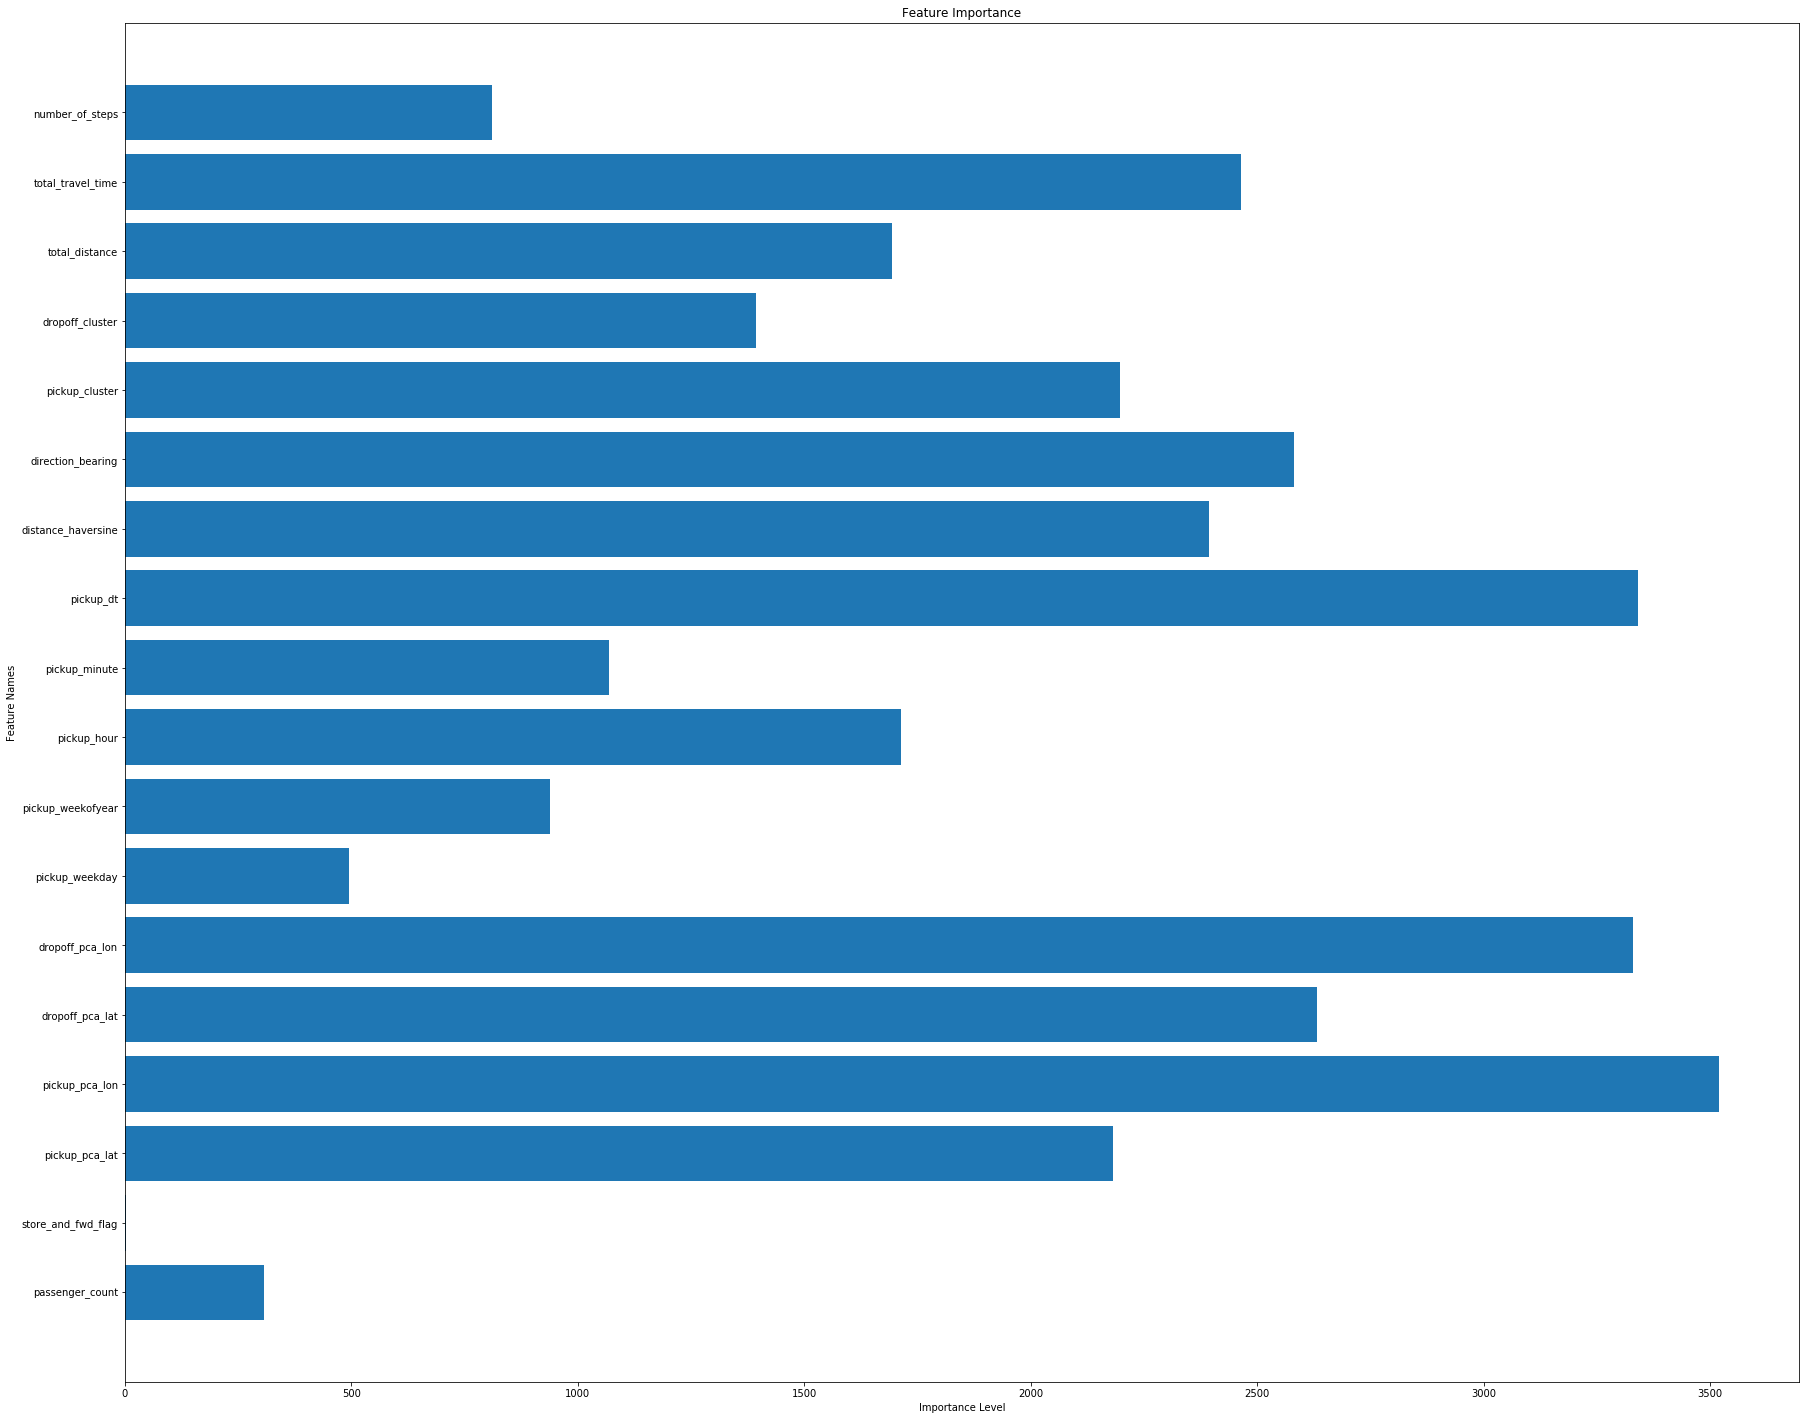

In [60]:
plt.rcParams['figure.figsize'] = (30,25)
plt.title('Feature Importance')
plt.xlabel('Importance Level')
plt.ylabel('Feature Names')
plt.barh( feature_importance['feature_name'],feature_importance['importance'])
plt.show()

The above plot shows the feature importance in the trained XGBoost model. High importance only means that the feature is used more number of times while making the tree splits in the model. To get the actual importance of the feature we can consider performing a feature wise elimination from the feature list based on the ascending order of the fscore of the feature.

In [61]:
print(features_to_use)

['passenger_count', 'store_and_fwd_flag', 'pickup_pca_lat', 'pickup_pca_lon', 'dropoff_pca_lat', 'dropoff_pca_lon', 'pickup_weekday', 'pickup_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_dt', 'distance_haversine', 'direction_bearing', 'pickup_cluster', 'dropoff_cluster', 'total_distance', 'total_travel_time', 'number_of_steps']


Below lines of code is used for finding the RMSE when the corresponding feature is removed from training the model

bckward_feature_list = imp_desc_df['feature_name'].values
rem_dict={}
for feature in bckward_feature_list:
    features_to_use.remove(feature)
    X_train, X_val, y_train, y_val = train_test_split(df_train[features_to_use].values,y,test_size=0.2,random_state=5)
    dat_train = xgb.DMatrix(X_train, label=y_train)
    dat_val = xgb.DMatrix(X_val, label=y_val)
    dat_test = xgb.DMatrix(df_test[features_to_use].values)
    watchlist=[(dat_train,'train'),(dat_val,'valid')]
    xgb_params = {'min_child_weight': 30, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,'subsample': 0.8, 
                  'lambda': 1., 'nthread': 3, 'booster' : 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
    xgb_model = xgb.train(xgb_params, dat_train, 100, watchlist, maximize=False, verbose_eval=100, early_stopping_rounds=70)
    print('Best Score after remomving the feature',feature,'is',xgb_model.best_score)
    rem_dict[feature] = xgb_model.best_score
    features_to_use.append(feature)

In [63]:
df_rem_feat_test = pd.DataFrame({'feature_name': list(rem_dict.keys()),
                                 'model_score_after_removal': list(rem_dict.values())})


In [64]:
df_model_test = pd.merge(feature_importance,df_rem_feat_test,how='left',on='feature_name')
display(df_model_test)

,f,feature_name,importance,model_score_after_removal
0,f0,passenger_count,308,0.383356
1,f1,store_and_fwd_flag,3,0.383567
2,f2,pickup_pca_lat,2181,0.385306
3,f3,pickup_pca_lon,3520,0.388943
4,f4,dropoff_pca_lat,2633,0.383296
5,f5,dropoff_pca_lon,3329,0.384773
6,f6,pickup_weekday,495,0.386109
7,f7,pickup_weekofyear,939,0.389361
8,f8,pickup_hour,1714,0.406486
9,f9,pickup_minute,1068,0.382695


We are measuring the feature importance based on the accuracy of the model when the corresponding feature is removed from the training the model. Each feature is removed from the xgbmodel and trained to get the best score of the model where the evaluation metric used is RMSE. Remember that we are predicting the log of the trip duratioon and hence RMSE is suitable since the actual evaluation metric is RMSLE.

The below visualization should help us understand the importance of wach feature used in the model.

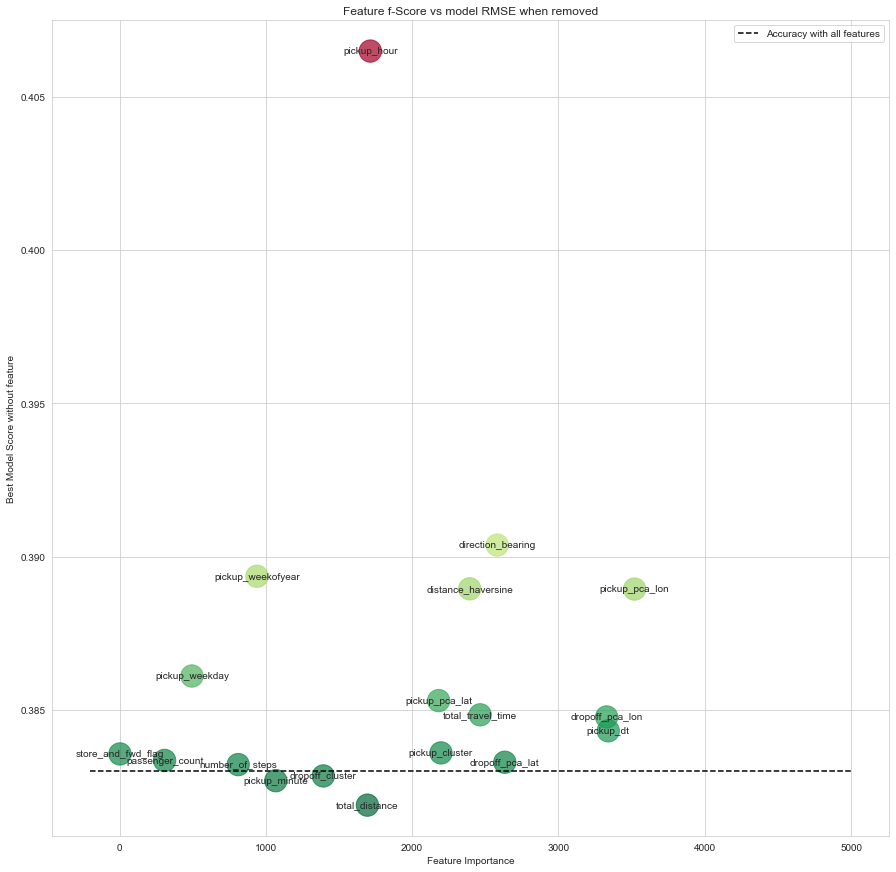

In [65]:
df_model_test = df_model_test.sort_values(by='model_score_after_removal', ascending=False)
df_model_test = df_model_test[df_model_test['model_score_after_removal'] > 0]
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.scatter(df_model_test['importance'].values, df_model_test['model_score_after_removal'].values,
               c=df_model_test['model_score_after_removal'].values, s=500, cmap='RdYlGn_r', alpha=0.7)
    for _, row in df_model_test.iterrows():
        ax.text(row['importance'], row['model_score_after_removal'], row['feature_name'],
                verticalalignment='center', horizontalalignment='center')
    ax.set_xlabel('Feature Importance')
    ax.set_ylabel('Best Model Score without feature')
    ax.set_ylim(np.min(df_model_test['model_score_after_removal']) - 0.001,
                np.max(df_model_test['model_score_after_removal']) + 0.001)
    ax.hlines(y=0.383,xmin=-200,xmax=5000,linestyle='dashed', label='Accuracy with all features')
    ax.set_title('Feature f-Score vs model RMSE when removed')
    ax.legend()
    plt.show()

The above graph plots the feature importance against the RMSE when the corresponding feature is removed.

**Observations**
1. The most important feature which when removed has hiked the RMSE is **'pickup_hour'**.
2. The RMSE from the base model increase for almost every feature except **'pickup_minute'**, **'dropoff_cluster'** and **'total_distance'**.
3. **'direction_bearing'**, **'pickup_weekofyear'**, **'distance_haversine'** and **'pickup_pca_lon'** are relatively imporant compared to the rest of the features

## Result Discussion

The primary dataset given to build a prediction model for the trip duration has most important features that helped to extract the intrumental features in the dataset. The most important factors that influence the trip duration can be summarised as the **hour of pickup**, **location of the pickup**, **distance to travel** and **direction of the destination** which makes a very practical sense.

The main challenges is identifying the instrumental features and quantifying them for the model training. I have chosen to keep all the features in the for training the model and predict the test results.

If I was to improve the model, I would recommend to get more information on the taxi data that would influence the trip duration which are as following,

1. Model of the Taxi.
2. Age of the Taxi.
3. Age of the Taxi driver.
4. Maintenance classification of the taxi (Well Maintained, Averagely Maintained, Poorly Maintained)


## Testset Prediction

In [69]:
ytest_pred = xgb_model.predict(dat_test)
df_test['trip_duration'] = np.exp(ytest_pred)-1
# save the test set to hard drive
df_test[['id', 'trip_duration']].to_csv('test_results.csv.gz', index=False, compression='gzip')

#### Plot of predicted result distribution

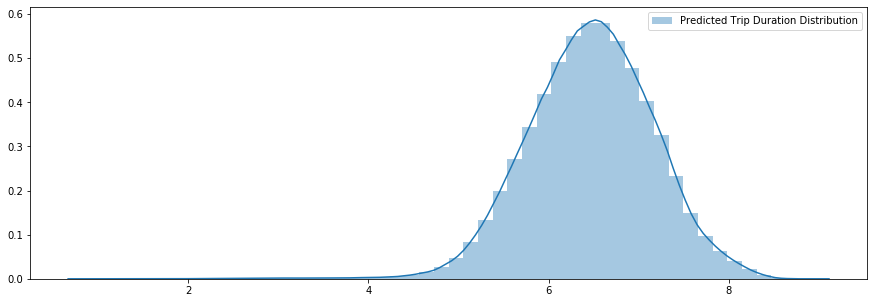

In [67]:
plt.rcParams['figure.figsize'] = (15,5)
sns.distplot(ytest_pred, label='Predicted Trip Duration Distribution')
plt.legend(loc='best')
plt.show()

In [68]:
print('Test data mean: %.3f' % ytest_pred.mean())

Test data mean: 6.466
